In [42]:
from IPython.display import display
import numpy as np
# import modin.pandas as pd
import pandas as pd
import datetime
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import warnings
import time
warnings.filterwarnings('ignore')

plt.style.use("fivethirtyeight")
sns.set_style({'font.sans-serif': ['simsun', 'Arial']})
sns.set_style('darkgrid', {'font.sans-serif': ['simhei', 'Arial']})
%matplotlib inline

np.random.seed(4590)

nf_data_path = r'../../Data/noFinacialFeatures.csv'
f_data_path = r''

In [9]:
nf_df = pd.read_csv(nf_data_path)
nf_df.head(5)

,企业编号,企业总评分,软著数量,作品著作数量,项目数量,纳税A级年份_2014,纳税A级年份_2015,纳税A级年份_2016,纳税A级年份_2017,资质证书数量,...,票面利率（%）_max,票面利率（%）_min,票面利率（%）_std,计划发行总额（亿元）_sum,计划发行总额（亿元）_max,计划发行总额（亿元）_min,计划发行总额（亿元）_std,城镇职工基本养老保险人数,保险实缴/人数,基数/人数
0,1001,75.374276,1.0,1.0,1.0,1.0,2.0,1.0,1.0,9.0,...,0.00,0.00,0.000000,0.0,0.0,0.0,0.000000,2176,17910.412479,43390.918022
1,1002,79.830122,2.0,0.0,1.0,1.0,1.0,2.0,0.0,0.0,...,4.35,3.05,0.712039,38.0,10.0,3.0,2.943920,2176,17910.412479,43390.918022
2,1003,78.318264,2.0,0.0,1.0,1.0,1.0,0.0,1.0,442.0,...,0.00,0.00,0.000000,0.0,0.0,0.0,0.000000,2176,17910.412479,43390.918022
3,1004,83.253376,0.0,6.0,1.0,0.0,0.0,2.0,1.0,1.0,...,5.50,3.88,0.580836,29.0,10.0,4.0,2.387467,2176,17910.412479,43390.918022
4,1005,83.291493,6.0,0.0,1.0,0.0,0.0,0.0,0.0,5.0,...,5.30,3.30,0.628865,70.0,10.0,3.0,2.943920,2176,17910.412479,43390.918022


In [10]:
# f_df = pd.read_csv(f_data_path)
# f_df.head(5)

In [33]:
df = nf_df.copy()

In [34]:
ytrain = df['企业总评分']
id_train = df['企业编号']
xtrain = df.drop(['企业编号', '企业总评分'], axis=1)

In [35]:
xtrain.shape

(2956, 90)

In [36]:
xtrain.head(5)

,软著数量,作品著作数量,项目数量,纳税A级年份_2014,纳税A级年份_2015,纳税A级年份_2016,纳税A级年份_2017,资质证书数量,android,ios,...,票面利率（%）_max,票面利率（%）_min,票面利率（%）_std,计划发行总额（亿元）_sum,计划发行总额（亿元）_max,计划发行总额（亿元）_min,计划发行总额（亿元）_std,城镇职工基本养老保险人数,保险实缴/人数,基数/人数
0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,9.0,4.0,10.0,...,0.00,0.00,0.000000,0.0,0.0,0.0,0.000000,2176,17910.412479,43390.918022
1,2.0,0.0,1.0,1.0,1.0,2.0,0.0,0.0,1.0,6.0,...,4.35,3.05,0.712039,38.0,10.0,3.0,2.943920,2176,17910.412479,43390.918022
2,2.0,0.0,1.0,1.0,1.0,0.0,1.0,442.0,0.0,0.0,...,0.00,0.00,0.000000,0.0,0.0,0.0,0.000000,2176,17910.412479,43390.918022
3,0.0,6.0,1.0,0.0,0.0,2.0,1.0,1.0,2.0,2.0,...,5.50,3.88,0.580836,29.0,10.0,4.0,2.387467,2176,17910.412479,43390.918022
4,6.0,0.0,1.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,5.30,3.30,0.628865,70.0,10.0,3.0,2.943920,2176,17910.412479,43390.918022


In [49]:
xtest = xtrain[:1000]
id_test = df['企业编号'][:1000]

In [45]:
nfolds = 10
folds = KFold(n_splits=nfolds, shuffle=True, random_state=15)

In [46]:
param = {'num_leaves': 50,
         'min_data_in_leaf': 30,
         'objective': 'regression',
         'max_depth': 10,
         'learning_rate': 0.005,
         "min_child_samples": 100,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1}

In [47]:
feature_importance_df = np.zeros((xtrain.shape[1], nfolds))
mvalid = np.zeros(len(xtrain))
mfull = np.zeros(len(xtest))


start = time.time()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(xtrain.values, ytrain.values)):
    print('----')
    print("fold n°{}".format(fold_))

    x0, y0 = xtrain.iloc[trn_idx], ytrain[trn_idx]
    x1, y1 = xtrain.iloc[val_idx], ytrain[val_idx]

    trn_data = lgb.Dataset(x0, label=y0)
    val_data = lgb.Dataset(x1, label=y1)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets=[trn_data, val_data],
                    verbose_eval=500, early_stopping_rounds=150)
    mvalid[val_idx] = clf.predict(x1, num_iteration=clf.best_iteration)

    feature_importance_df[:, fold_] = clf.feature_importance()

    mfull += clf.predict(xtest,
                         num_iteration=clf.best_iteration) / folds.n_splits

----
fold n°0
Training until validation scores don't improve for 150 rounds.
[500]	training's rmse: 2.55021	valid_1's rmse: 3.10164
[1000]	training's rmse: 2.15586	valid_1's rmse: 3.01932
Early stopping, best iteration is:
[1152]	training's rmse: 2.0837	valid_1's rmse: 3.01603
----
fold n°1
Training until validation scores don't improve for 150 rounds.
[500]	training's rmse: 2.53875	valid_1's rmse: 3.1842
Early stopping, best iteration is:
[745]	training's rmse: 2.29966	valid_1's rmse: 3.15648
----
fold n°2
Training until validation scores don't improve for 150 rounds.
[500]	training's rmse: 2.52204	valid_1's rmse: 3.18933
Early stopping, best iteration is:
[709]	training's rmse: 2.31428	valid_1's rmse: 3.17174
----
fold n°3
Training until validation scores don't improve for 150 rounds.
[500]	training's rmse: 2.54012	valid_1's rmse: 3.22204
[1000]	training's rmse: 2.13652	valid_1's rmse: 3.13606
Early stopping, best iteration is:
[1197]	training's rmse: 2.04574	valid_1's rmse: 3.13019


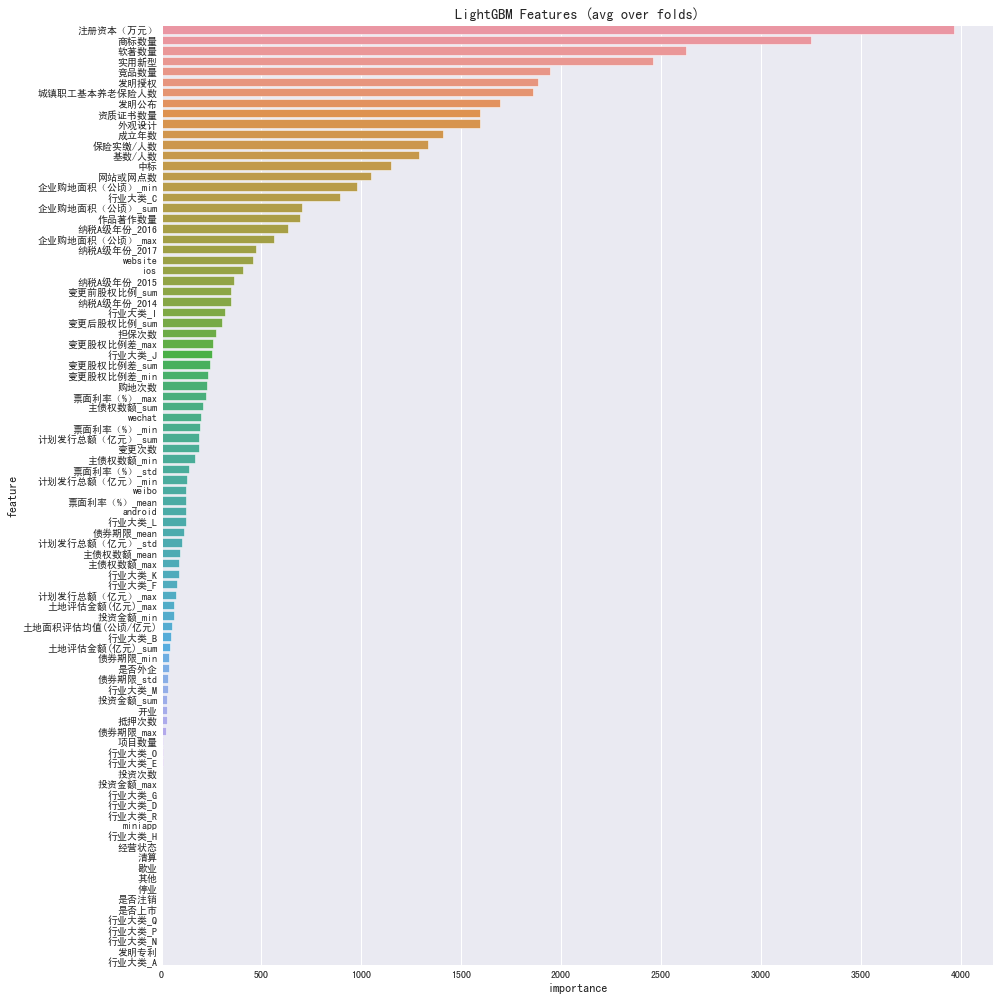

In [48]:
ximp = pd.DataFrame()
ximp['feature'] = xtrain.columns
ximp['importance'] = feature_importance_df.mean(axis=1)

plt.figure(figsize=(14, 14))
sns.barplot(x="importance",
            y="feature",
            data=ximp.sort_values(by="importance",
                                  ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

In [51]:
xsub = pd.DataFrame()
xsub['企业编号'] = id_test
xsub['企业总评分'] = mfull.astype(int)
xsub.to_csv('sub_lgb_no_scaling.csv', index=False)